In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T130717Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D52b44fe7fd78b2b24b20a6dd420d3f5f00b78070babbac618af7b829a0ca2c14cf8ef24649bb9bf9a0c245f5b3183a659e55bec5426b1785f15e63f7c97e4db7002bd7c56e9d8c22aa121826a74a516dd96eb6804c80793cc1577861ca3b105a957737341279a472ac1063122245bd965fb69f23a6a64c39f97179f5f16261709b1c26e55ff4adcf4c6a02a541b3260204ae8c46bc4b918cdf2b08f9c07c43fd03d84ae23490ff10a8ecf1d35722997acdc1e5f41342c62e643f0f4654c0d6274d64d55985c15ff39e8d4612704b2734c554c27198a944b09ec429befbce0d9c3c22070e86d132120c8fa5c51cbc64dc0029d288f7d56c4b265c9ae8c1493a9d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 155791278 bytes downloaded
Downloaded and uncompressed: brain-tumor-mri-dataset
Data source import complete.


# Brain Tumor MRI Dataset
Check this link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

# **Importing Packages**

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 # helps you read image data

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob  #travel in directory and grab all the files of certain extension I want

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score



# **Read the images**

In [ ]:
def load_images_from_directory(path, target_size=(128, 128)):
    images = []
    for f in glob.iglob(path):
        img = cv2.imread(f)
        if img is None:
            print(f"Failed to load image: {f}")
            continue
        img = cv2.resize(img, target_size)  # Resize to target size
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])  # Convert BGR to RGB
        images.append(img)
    print(f"Number of images loaded from {path}: {len(images)}")
    return images

notumor = load_images_from_directory(r'/kaggle/input/brain-tumor-mri-dataset/Training/notumor/*.jpg')
pituitary = load_images_from_directory(r'/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/*.jpg')
meningioma = load_images_from_directory(r'/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/*.jpg')
glioma = load_images_from_directory(r'/kaggle/input/brain-tumor-mri-dataset/Training/glioma/*.jpg')


Number of images loaded from /kaggle/input/brain-tumor-mri-dataset/Training/notumor/*.jpg: 1595
Number of images loaded from /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/*.jpg: 1457
Number of images loaded from /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/*.jpg: 1339
Number of images loaded from /kaggle/input/brain-tumor-mri-dataset/Training/glioma/*.jpg: 1321


In [ ]:
categories = {
    'pituitary_': np.array(pituitary),
    'notumor_': np.array(notumor),
    'meningioma_': np.array(meningioma),
    'glioma_': np.array(glioma)
}

All = np.concatenate(list(categories.values()))

print(f"Combined array shape: {All.shape}")


Combined array shape: (5712, 128, 128, 3)


# **Visualizing Brain MRI Images¶**

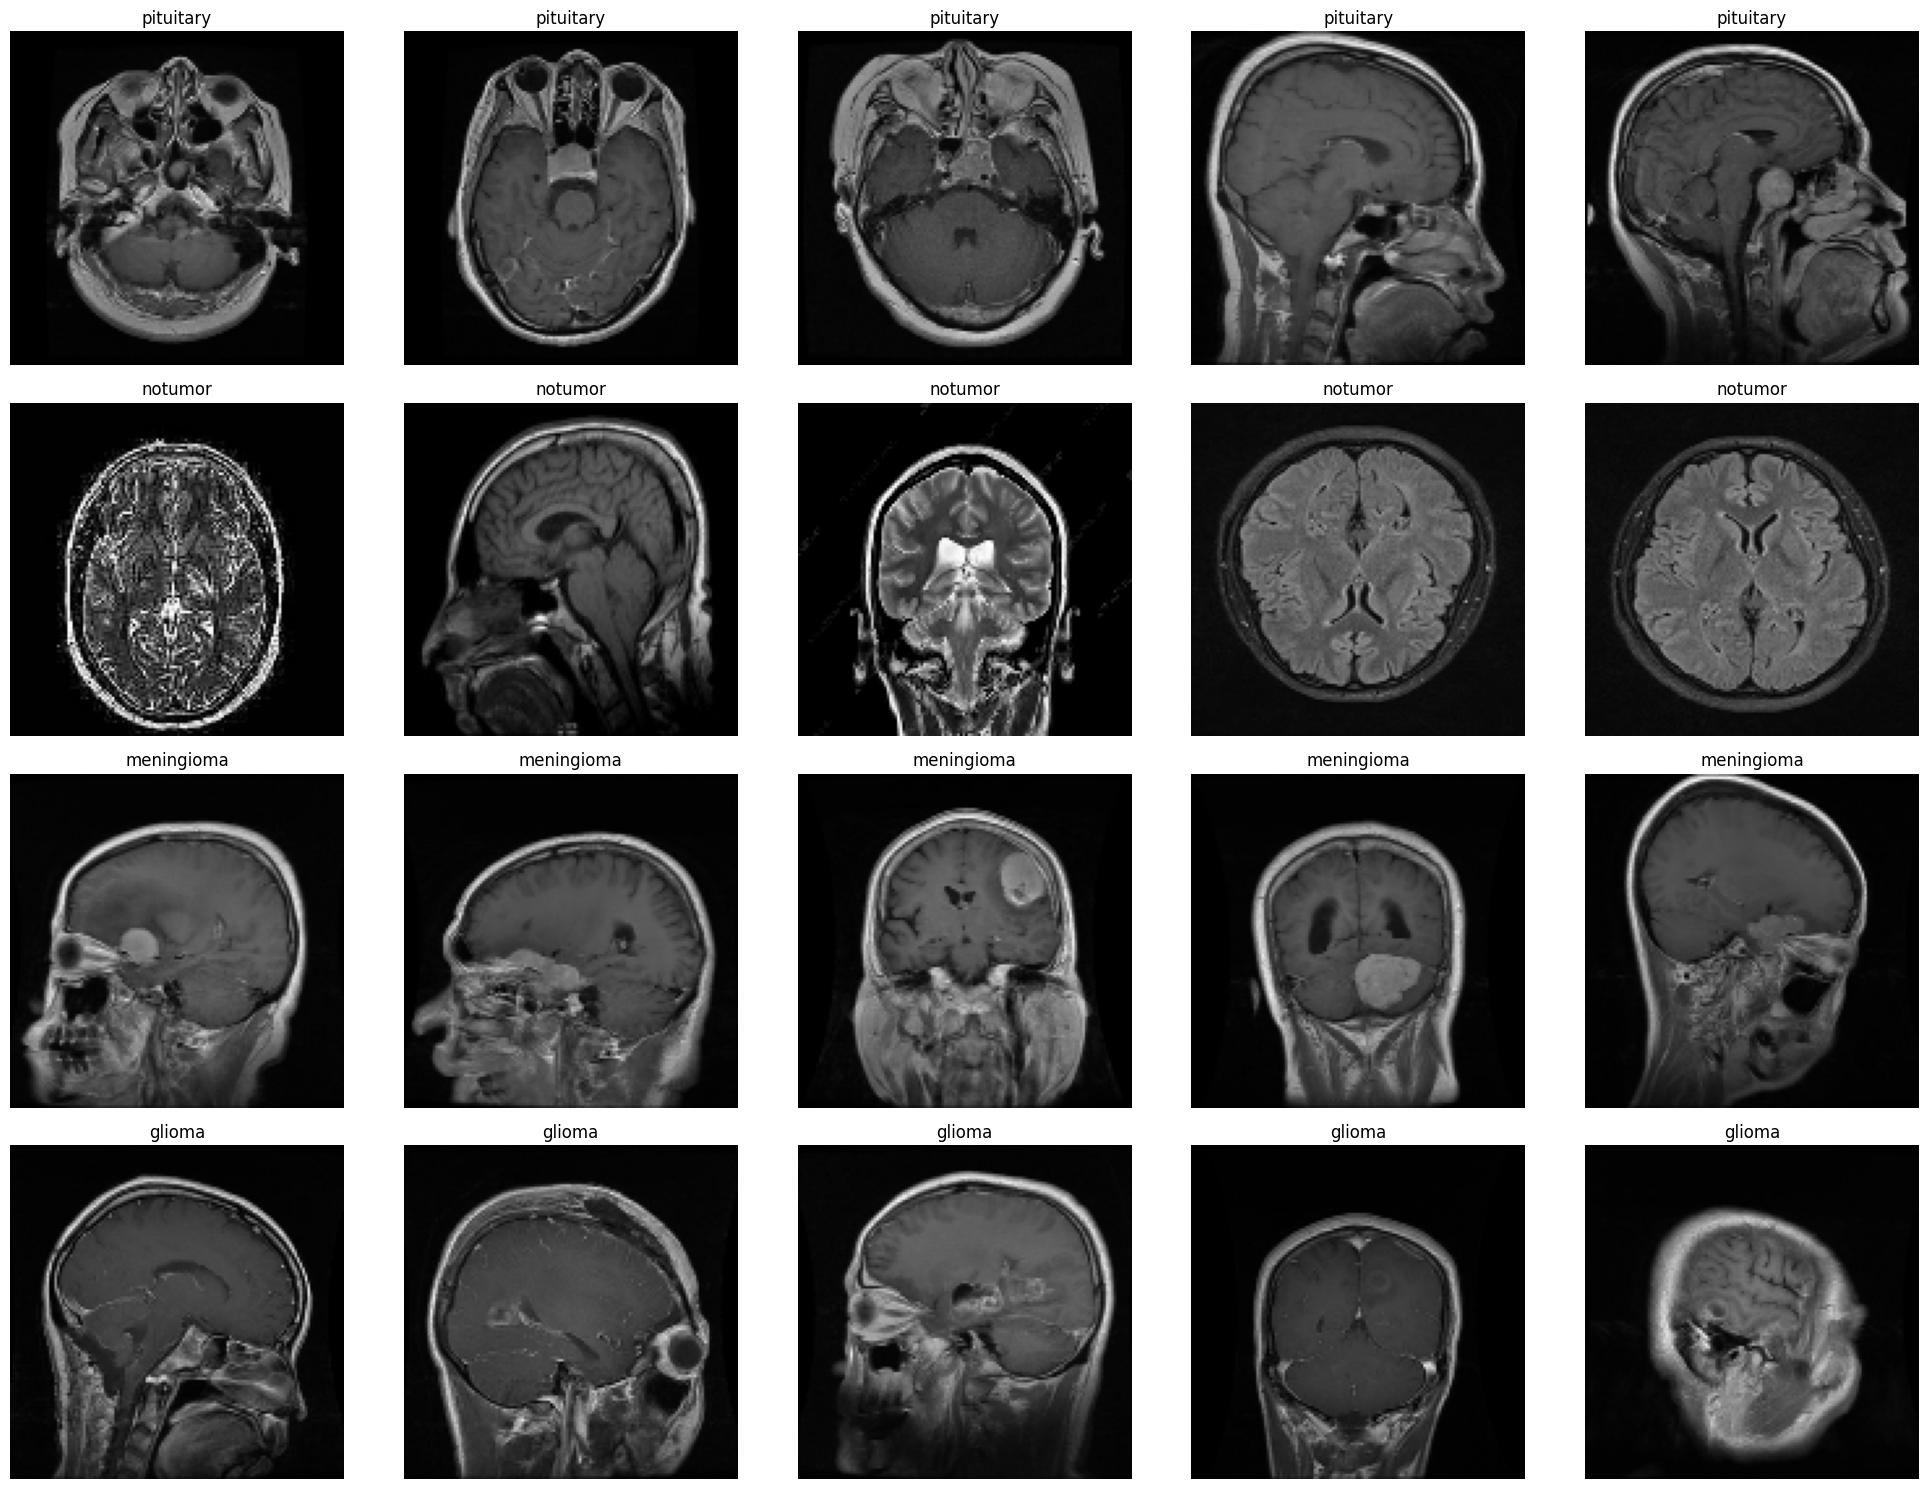

In [ ]:
def display_sample_images(categories, num_samples=5):
    plt.figure(figsize=(20, 15))

    for i, (category, images) in enumerate(categories.items()):
        # Check if there are enough images to sample from
        num_to_sample = min(num_samples, len(images))

        # Randomly select sample images (flattening is unnecessary if images are already in the correct shape)
        sample_images_indices = np.random.choice(len(images), size=num_to_sample, replace=False)
        sample_images = [images[idx] for idx in sample_images_indices]

        for j, img in enumerate(sample_images):
            plt.subplot(len(categories), num_samples, i * num_samples + j + 1)
            plt.imshow(img)  # Display the image
            plt.axis('off')  # Hide axes
            plt.title(category[:-1])  # Set title for each category

    plt.tight_layout()
    plt.show()

display_sample_images(categories)


# **Create MRI Custom Database**

In [ ]:
class MRI(Dataset):
    def __init__(self, data_dir):
        self.images = []
        self.labels = []

        # Define category names and their corresponding labels
        categories = {
            'notumor': 0,
            'pituitary': 1,
            'meningioma': 2,
            'glioma': 3
        }

        # Load images and labels for each category
        for category, label in categories.items():
            # Adjust the path according to your folder structure
            path = f"{data_dir}/{category}/*.jpg"
            images = self.load_images_from_directory(path)
            self.images.extend(images)
            self.labels.extend([label] * len(images))

        # Convert lists to numpy arrays
        self.images = np.array(self.images, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.float32)

    def load_images_from_directory(self, path, target_size=(128, 128)):

        images = [
        cv2.cvtColor(cv2.resize(cv2.imread(f), target_size), cv2.COLOR_BGR2RGB)
        for f in glob.iglob(path) if cv2.imread(f) is not None
    ]

        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0


In [ ]:
train_MRI= MRI(r'/kaggle/input/brain-tumor-mri-dataset/Training')
test_MRI= MRI(r'/kaggle/input/brain-tumor-mri-dataset/Testing')

In [ ]:
train_MRI.normalize()
test_MRI.normalize()

# **Creating a Dataloader**

In [ ]:
train_loader= DataLoader(train_MRI, batch_size=8, shuffle=True)
val_loader = DataLoader(test_MRI, batch_size=8, shuffle=False)

# **Create a model**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Change from 1 to 3
            nn.BatchNorm2d(32),  # Update this to match out_channels
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output size: (32, H/2, W/2)

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output size: (32, H/4, W/4)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output size: (64, H/8, W/8)

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output size: (128, H/16, W/16)

            nn.AdaptiveAvgPool2d((1, 1))  # Output size: (128, 1, 1)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),  # Adjust in_features based on CNN output
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=128, out_features=84),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=84, out_features=4)  # Final layer for 4 classes
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_model(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)  # Apply softmax to get probabilities
        return probabilities


# **Training The Model**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Appropriate for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0004)

In [ ]:
def train(model, train_loader, optimizer, criterion, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i, D in enumerate(train_loader):
            images = D['image'].to(device)
            labels = D['label'].to(device)

             # Reshape images from [batch_size, height, width, channels] to [batch_size, channels, height, width]
            images = images.permute(0, 3, 1, 2)

            # print(images.shape)

            labels = labels.long()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            # Backward pass and optimization
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Update the weights

            running_loss += loss.item()

        # Print epoch loss
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}')


In [ ]:
train(model, train_loader, optimizer, criterion, epochs=70)

Epoch [1/70], Loss: 0.9003
Epoch [2/70], Loss: 0.6686
Epoch [3/70], Loss: 0.6114
Epoch [4/70], Loss: 0.5356
Epoch [5/70], Loss: 0.4916
Epoch [6/70], Loss: 0.4455
Epoch [7/70], Loss: 0.4330
Epoch [8/70], Loss: 0.4248
Epoch [9/70], Loss: 0.3932
Epoch [10/70], Loss: 0.3794
Epoch [11/70], Loss: 0.3849
Epoch [12/70], Loss: 0.3461
Epoch [13/70], Loss: 0.3371
Epoch [14/70], Loss: 0.3344
Epoch [15/70], Loss: 0.3252
Epoch [16/70], Loss: 0.3027
Epoch [17/70], Loss: 0.2818
Epoch [18/70], Loss: 0.2783
Epoch [19/70], Loss: 0.2783
Epoch [20/70], Loss: 0.2551
Epoch [21/70], Loss: 0.2425
Epoch [22/70], Loss: 0.2440
Epoch [23/70], Loss: 0.2287
Epoch [24/70], Loss: 0.2233
Epoch [25/70], Loss: 0.2224
Epoch [26/70], Loss: 0.2073
Epoch [27/70], Loss: 0.2003
Epoch [28/70], Loss: 0.1940
Epoch [29/70], Loss: 0.1989
Epoch [30/70], Loss: 0.1785
Epoch [31/70], Loss: 0.1761
Epoch [32/70], Loss: 0.1789
Epoch [33/70], Loss: 0.1708
Epoch [34/70], Loss: 0.1628
Epoch [35/70], Loss: 0.1511
Epoch [36/70], Loss: 0.1493
E

In [ ]:
def evaluate_model(model, dataloader, device, return_images=False):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    all_probs = []
    all_images = []

    with torch.no_grad():
        for D in dataloader:
            images = D['image'].to(device)  # Move images to the device
            labels = D['label'].to(device)  # Move labels to the device
            images = images.permute(0, 3, 1, 2)  # Change channel order

            y_hat = model(images)  # Get model predictions
            y_hat_probs = torch.softmax(y_hat, dim=1)  # Apply softmax for probabilities

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(torch.argmax(y_hat_probs, dim=1).cpu().numpy())  # Get predicted classes
            all_probs.append(y_hat_probs.cpu().numpy())  # Store probabilities
            if return_images:
                all_images.append(images.cpu())  # Store images for visualization

    all_labels = np.concatenate(all_labels)
    all_predictions = np.concatenate(all_predictions)
    all_probs = np.concatenate(all_probs)

    if return_images:
        all_images = torch.cat(all_images)  # Combine images into a single tensor
        return all_labels, all_predictions, all_probs, all_images
    return all_labels, all_predictions, all_probs


In [ ]:
def plot_results(true_labels, predicted_labels, predicted_probs, n_classes):
    # Calculate and print accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Accuracy: {accuracy:.4f}')

    # Compute confusion matrix and print classification report
    cm = confusion_matrix(true_labels, predicted_labels)
    print(classification_report(true_labels, predicted_labels))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate ROC-AUC for each class
    roc_auc_scores = []
    for i in range(n_classes):
        roc_auc = roc_auc_score((true_labels == i).astype(int), predicted_probs[:, i])
        roc_auc_scores.append(roc_auc)

    print("ROC-AUC Scores for each class:", roc_auc_scores)


In [ ]:
def plot_misclassified_images(images, true_labels, predicted_labels, n_cols=5):
    misclassified_indices = np.where(true_labels != predicted_labels)[0]
    n_misclassified = len(misclassified_indices)
    n_rows = (n_misclassified + n_cols - 1) // n_cols  # Calculate number of rows needed

    plt.figure(figsize=(15, n_rows * 3))
    for i, index in enumerate(misclassified_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[index].permute(1, 2, 0).numpy())  # Change channel order for visualization
        plt.title(f'True: {true_labels[index]}\nPred: {predicted_labels[index]}', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Accuracy: 0.9703
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       405
         1.0       0.99      0.99      0.99       300
         2.0       0.92      0.96      0.94       306
         3.0       0.98      0.92      0.95       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



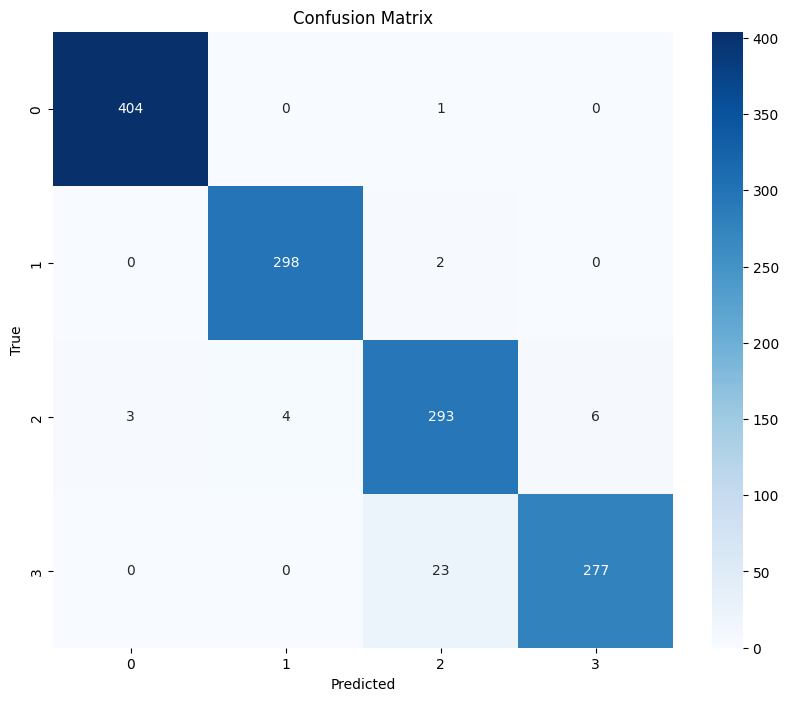

ROC-AUC Scores for each class: [0.999959120268171, 0.9999109792284867, 0.996488147497805, 0.9982492581602374]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
true_labels, predicted_labels, predicted_probs, misclassified_images = evaluate_model(model, val_loader, device, return_images=True)
n_classes = predicted_probs.shape[1]  # Number of classes
plot_results(true_labels, predicted_labels, predicted_probs, n_classes)  # Evaluate and plot results

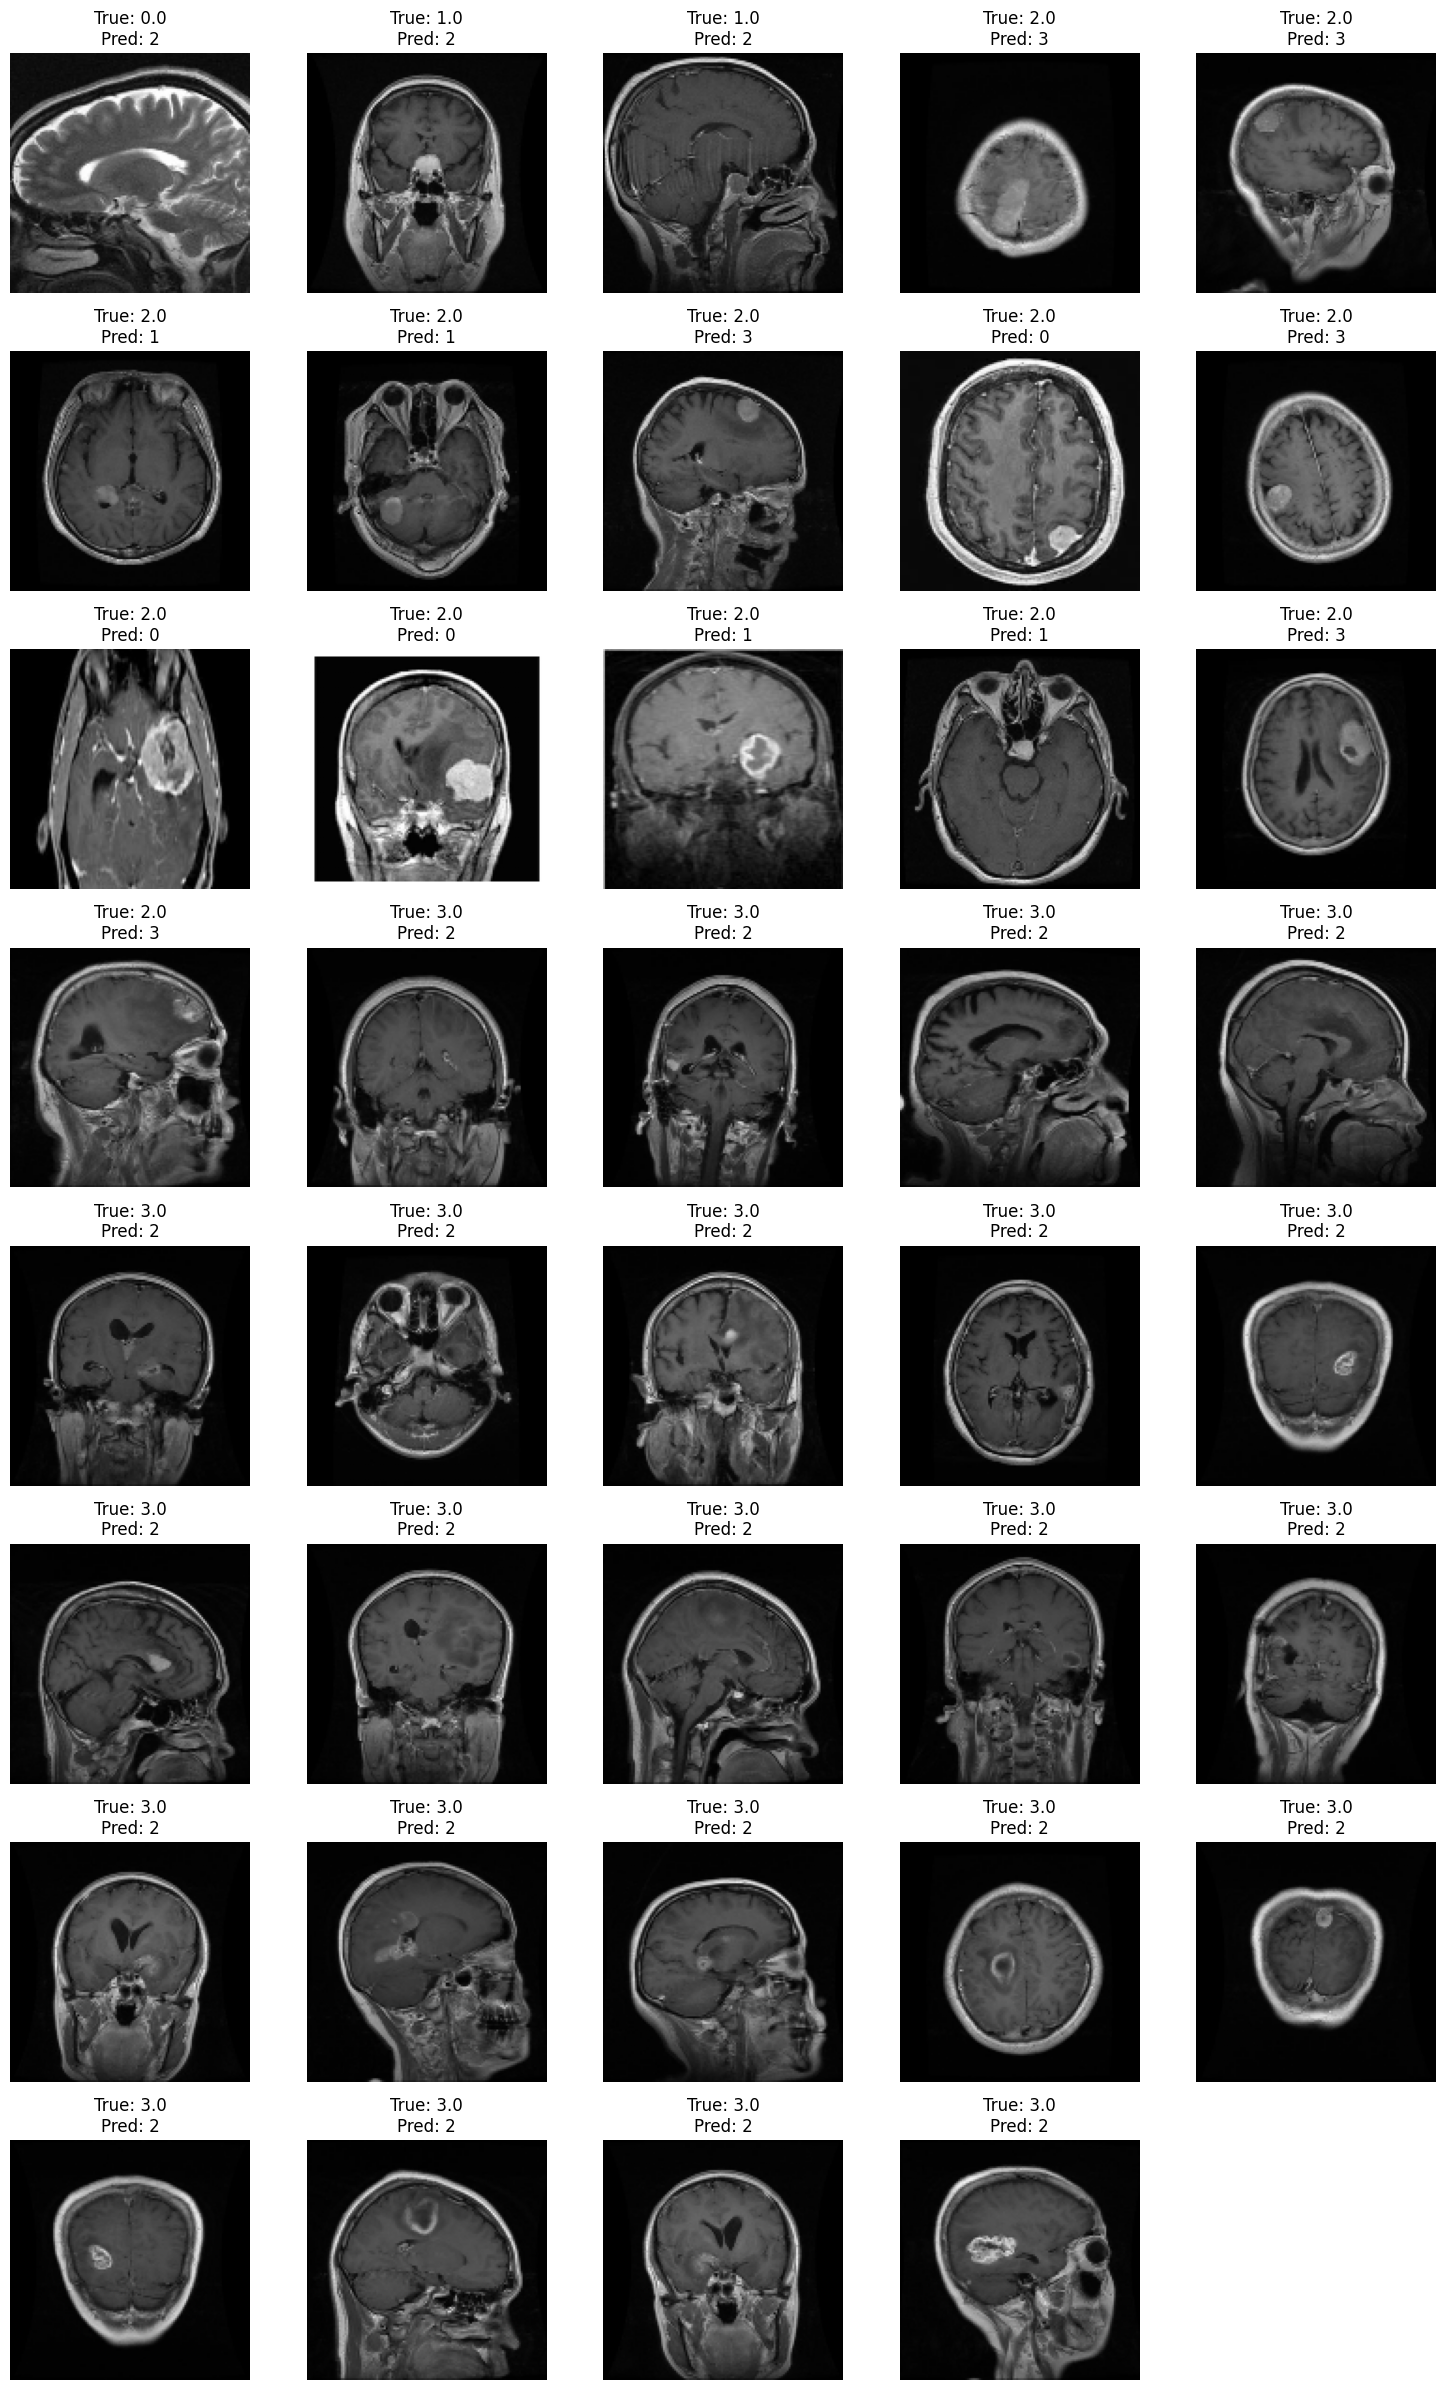

In [ ]:
plot_misclassified_images(misclassified_images, true_labels, predicted_labels)  # Visualize misclassifications

In [ ]:
import torch

# Save the model state dictionary
torch.save(model.state_dict(), 'model.pth')


In [ ]:
from google.colab import files

# Download the saved model
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>